In [150]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import sqlite3
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time,warnings

from sklearn.linear_model import LinearRegression

In [151]:
conn = sqlite3.connect('../queries/retail.db')
df = pd.read_sql_query("SELECT * FROM mostvalue_client WHERE CustomerId IS NOT NULL", conn)
conn.close()

df.isnull().sum()
df.head()

,CustomerId,total_items,unique_items,avg_price_unit,Revenue
0,14646.0,2085,703,2.59,279489.02
1,18102.0,433,151,11.92,256438.49
2,17450.0,351,127,9.46,187482.17
3,14911.0,5903,1794,5.26,132572.62
4,12415.0,778,444,3.21,123725.45


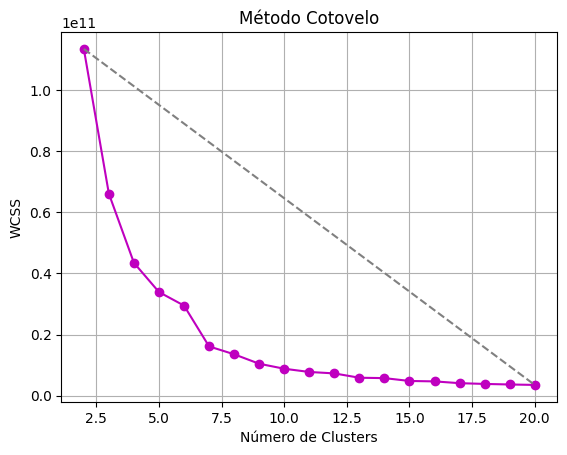

In [152]:

def calculate_wcss(data):
    wcss = []

    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    
    return wcss

wcss = calculate_wcss(df)
plt.plot(range(2,21), wcss, marker='o', color='m')
plt.plot([2, 20], [wcss[0], wcss[-1]], color='gray', linestyle='--')
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método Cotovelo')
plt.show()


Estamos procurando o ponto que indica o maior equilíbrio entre maior homogeneidade dentro do cluster e a mior diferenca entre clusters, é o ponto da curva mais distante de uma reta tracaada entre os ponto (2, 20)

E temos a formula que calcula essa maior distância no nosso modelo: 

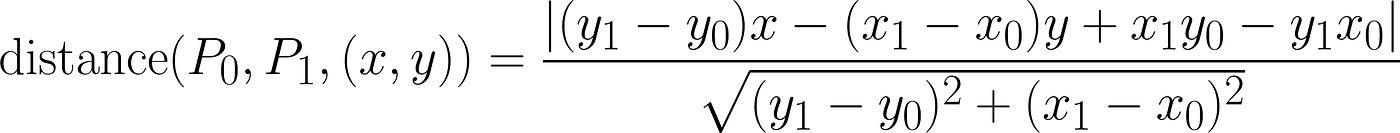

O nosso P0 é nosso: 2
O nosso P1 é nosso: 20

In [153]:
def good_optional_cluster(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[-1]

    distance = []

    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distance.append(numerator / denominator)
    
    return distance.index(max(distance)) + 2

In [154]:
n = good_optional_cluster(wcss)
print(f'Número ótimo: {n} Clusters')

Número ótimo: 7 Clusters


In [155]:
kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)
kmeans.fit(df)

df['Cluster'] = kmeans.labels_

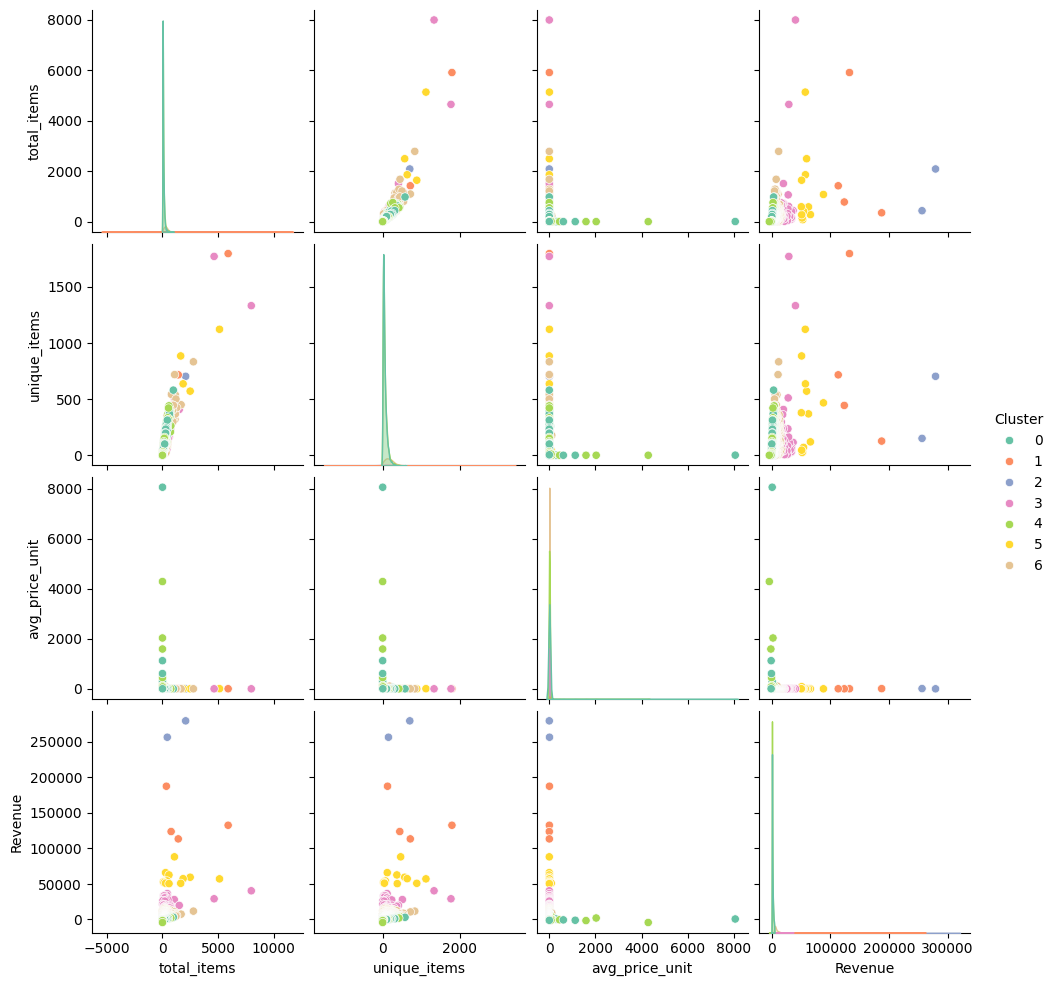

In [158]:
df.groupby('Cluster').describe()
df.groupby('Cluster').mean()
df = df.drop(columns=['CustomerId'])
sns.pairplot(df, hue='Cluster', palette='Set2')


In [161]:
resultados = {}

for cluster in df['Cluster'].unique():
    dados_cluster = df[df['Cluster'] == cluster]
    
    X = dados_cluster.drop(columns=['Revenue', 'Cluster'])
    y = dados_cluster['Revenue']

    model = LinearRegression()
    model.fit(X, y)

    resultados[cluster] = model
    print(f"Cluster {cluster} - Coeficientes: {model.coef_}")

Cluster 2 - Coeficientes: [12.55134899  4.19391322 -0.07088625]
Cluster 1 - Coeficientes: [  43.17032772 -164.62391892 4800.74682212]
Cluster 5 - Coeficientes: [  -0.57814725    2.73250412 -101.44003369]
Cluster 3 - Coeficientes: [   3.64248732   -8.72045542 -265.73435066]
Cluster 6 - Coeficientes: [ 3.44377836 -6.22577973 23.46463668]
Cluster 4 - Coeficientes: [ 7.52958219 -1.45507232 -0.79086699]
Cluster 0 - Coeficientes: [ 6.52904233  2.61448888 -0.00789256]


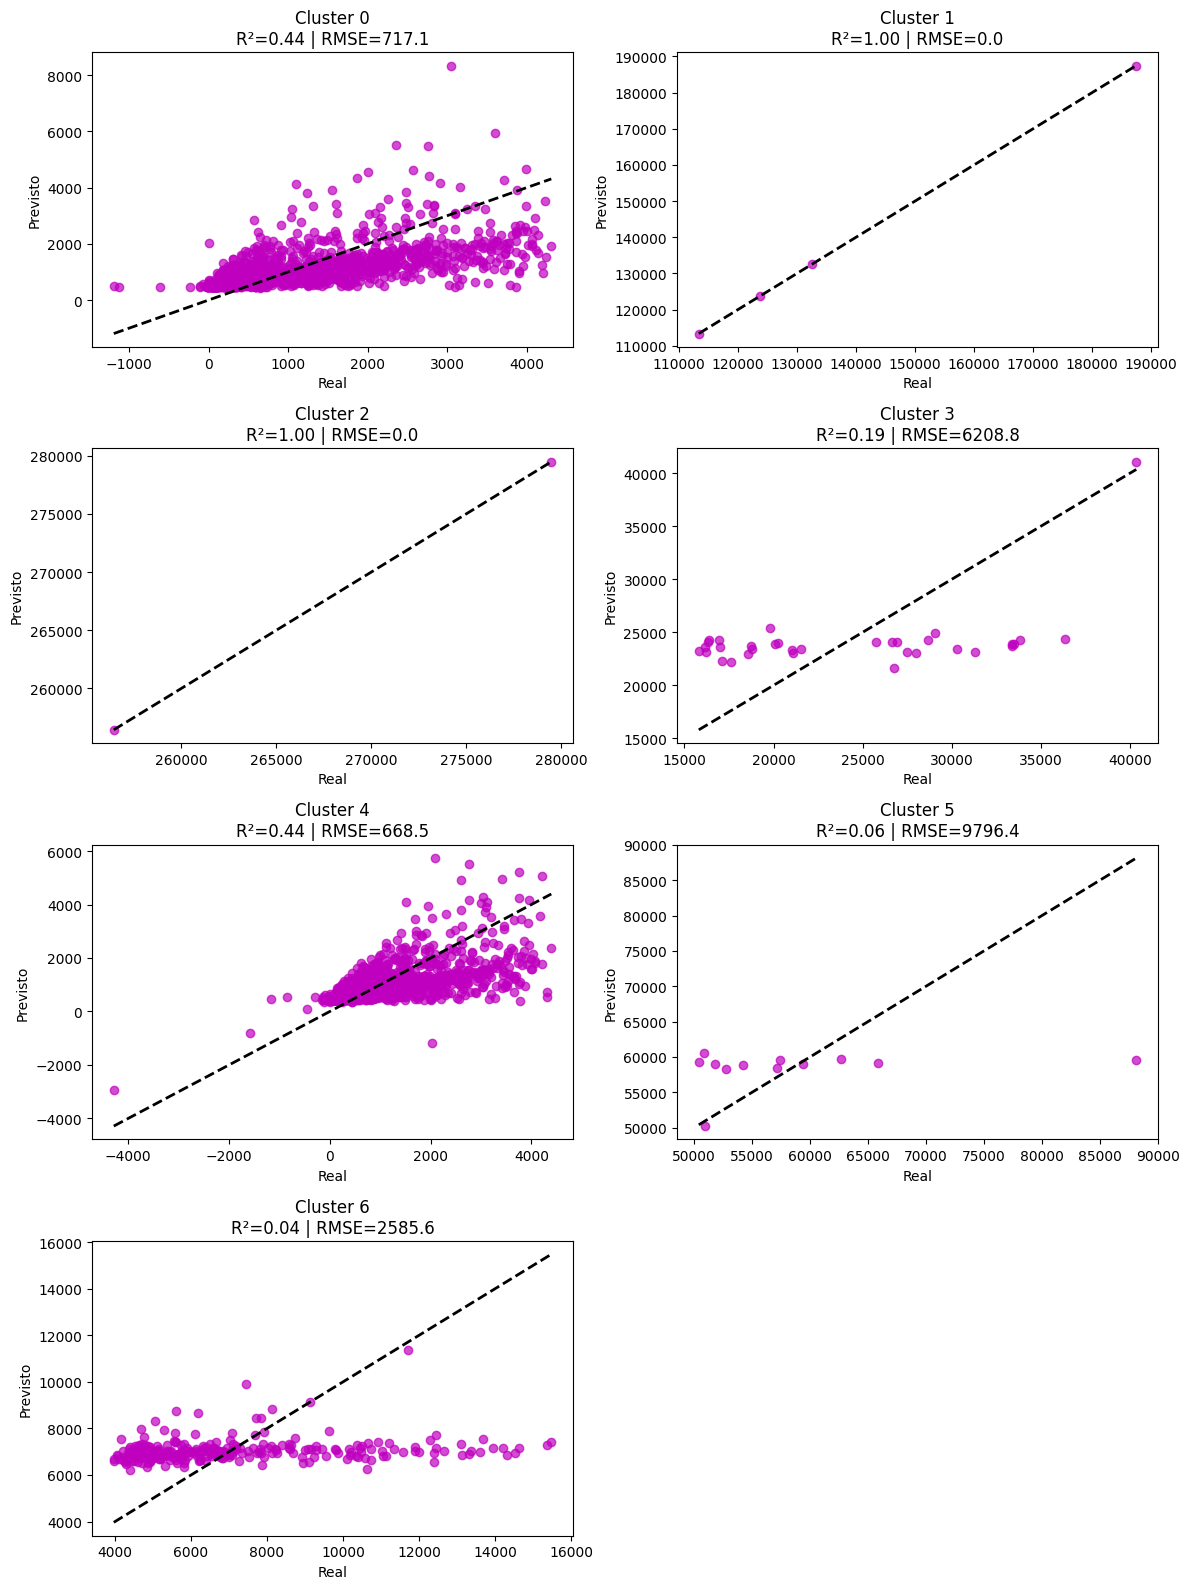

In [176]:
import matplotlib.pyplot as plt

clusters_unicos = sorted(df['Cluster'].unique())
cols = 2
rows = int(np.ceil(len(clusters_unicos) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for i, cluster in enumerate(clusters_unicos):
    dados_cluster = df[df['Cluster'] == cluster]
    X = dados_cluster.drop(columns=['Revenue', 'Cluster'])
    y = dados_cluster['Revenue']
    
    model = resultados[cluster]
    y_pred = model.predict(X)
    
    ax = axes[i]
    ax.scatter(y, y_pred, alpha=0.7, color='m')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_title(f'Cluster {cluster}\nR²={metricas[cluster]["Rˆ2"]:.2f} | RMSE={metricas[cluster]["RMSE"]:.1f}')
    ax.set_xlabel('Real')
    ax.set_ylabel('Previsto')

# Remove gráficos vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
